In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader

from torchvision import datasets, transforms
from torchvision.utils import make_grid

from matplotlib import pyplot as plt

import numpy as np

import time

In [2]:
class RBM(nn.Module):
    
    def __init__(self, n_vis, n_hid, k):
        
        super(RBM, self).__init__()
        
        self.W = torch.randn(n_hid, n_vis)
        self.v_bias = torch.randn((n_vis,))
        self.h_bias = torch.randn((n_hid,))
        self.k = k
        
    def v_to_h(self, v):
        '''
        Gibbs sampling of every hidden states (h) from every visible states (v) in one step (in parallel) 
        '''
        p = torch.sigmoid(F.linear(v, self.W, self.h_bias))
        h = p.bernoulli()
        return h
    
    def h_to_v(self, h):
        '''
        Gibbs sampling of every visible states (v) from every hidden states (h) in one step (in parallel)
        '''
        p = torch.sigmoid(F.linear(h, self.W.T, self.v_bias))
        v = p.bernoulli()
        return v
    
    def cd_learning(self, v_data, lr):
        '''
        Starting from v_data, run alternating parallel Gibbs sampling for k steps to get v_recon
        
        Then, update the parameters:
        
              W += lr * (<vh>_data - <vh>_recon)
              v_bias += lr * (<v>_data - <v>_recon)
              h_bias += lr * (<h>_data - <h>_recon)
              
        where <>_data is expectation by sampling from data distribution 
        and <>_recon is expectation by sampling from recon distribution after the k steps
        '''
        h_data = self.v_to_h(v_data)
        vh_data = torch.einsum('ab,ac->abc', h_data, v_data)
        
        h_recon = h_data
        for _ in range(self.k):
            v_recon = self.h_to_v(h_recon)
            h_recon = self.v_to_h(v_recon)
        vh_recon = torch.einsum('ab,ac->abc', h_recon, v_recon)
        
        self.W += lr * (vh_data.mean(axis=0) - vh_recon.mean(axis=0))
        self.v_bias += lr * (v_data.mean(axis=0) - v_recon.mean(axis=0))
        self.h_bias += lr * (h_data.mean(axis=0) - h_recon.mean(axis=0))
        
        error = F.mse_loss(v_recon, v_data).item()
        
        return error
    
    def forward(self, v_data):

        h = self.v_to_h(v_data)
        v_recon = self.h_to_v(h)
        
        return v_data, v_recon

In [14]:
def show_and_save_grid(v, name):
    grid = make_grid(v.view(32, 1, 28, 28).data)
    npimg = np.transpose(grid.numpy(), (1, 2, 0))
    plt.imshow(npimg, cmap='gray')
    plt.savefig(name)

In [15]:
dataset = datasets.MNIST('../dataset', train=True, download=True,
                   transform=transforms.ToTensor())

In [16]:
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

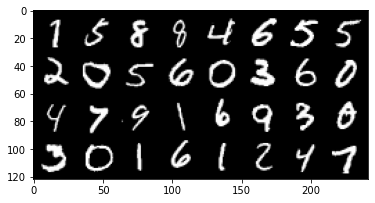

In [17]:
test_images = next(iter(train_loader))[0]
show_and_save_grid(test_images.view(-1,784), 'real.png')

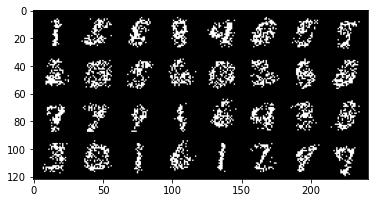

In [24]:
train_time = []
train_error = []
for k in [1, 2, 4, 8, 16, 32, 64]:
    model = RBM(784, 64, k)
    lr = 1.0
    tic = time.time()
    error = 0
    for epoch in range(1, 6):
        for images, _ in train_loader:
            error += model.cd_learning(images.view(-1,784), lr/epoch)
    train_time.append((time.time() - tic)/5)
    train_error.append(error/len(train_loader)/5)
    _, v = model(test_images.view(-1,784))
    show_and_save_grid(v, 'hidden_64_k_{}.png'.format(k))

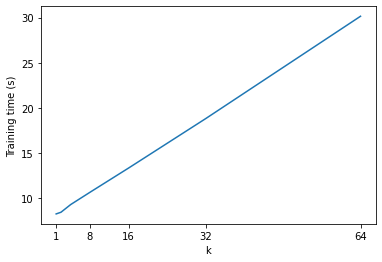

In [27]:
k = [1, 2, 4, 8, 16, 32, 64]
plt.plot(k, train_time)
plt.ylabel('Training time (s)')
plt.xticks(ticks=[1,8,16,32,64])
plt.xlabel('k')
plt.savefig('tt_vs_k_h_64.png')
plt.show()
plt.plot(k, train_error)
plt.ylabel('Mean squared error')
plt.xticks(ticks=[1,8,16,32,64])
plt.xlabel('k')
plt.savefig('te_vs_k_h_64.png')
plt.show()

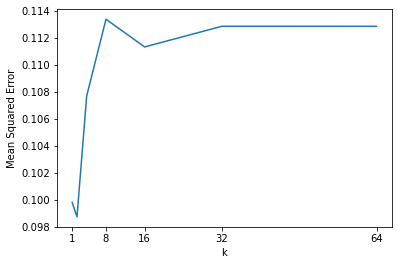

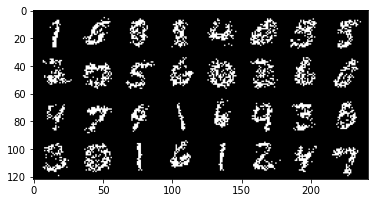

In [31]:
train_time = []
train_error = []
for h in [1, 2, 4, 8, 16, 32, 64, 128]:
    model = RBM(784, h, 1)
    lr = 1.0
    tic = time.time()
    error = 0
    for epoch in range(1, 6):
        for images, _ in train_loader:
            error += model.cd_learning(images.view(-1,784), lr/epoch)
    train_time.append((time.time() - tic)/5)
    train_error.append(error/len(train_loader)/5)
    _, v = model(test_images.view(-1,784))
    show_and_save_grid(v, 'hidden_{}.png'.format(h))

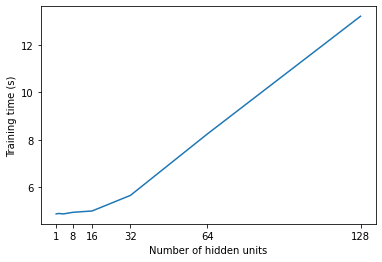

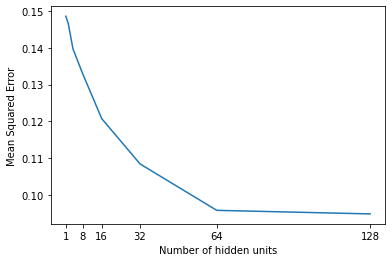

In [32]:
h = [1, 2, 4, 8, 16, 32, 64, 128]
plt.plot(h, train_time)
plt.ylabel('Training time (s)')
plt.xticks(ticks=[1,8,16,32,64,128])
plt.xlabel('Number of hidden units')
plt.savefig('tt_vs_h.png')
plt.show()
plt.plot(h, train_error)
plt.ylabel('Mean squared error')
plt.xticks(ticks=[1,8,16,32,64,128])
plt.xlabel('Number of hidden units')
plt.savefig('te_vs_h.png')                                                                                                                     
plt.show()

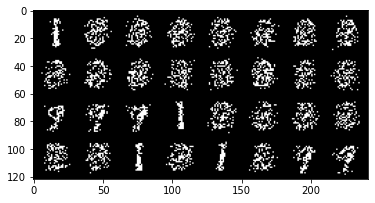

In [39]:
train_time = []
train_error = []
for lr in [1.0, 2.0, 4.0, 8.0]:
    model = RBM(784, 128, 1)
    tic = time.time()
    error = 0
    for epoch in range(1, 6):
        for images, _ in train_loader:
            error += model.cd_learning(images.view(-1,784), lr)
    train_time.append((time.time() - tic)/5)
    train_error.append(error/len(train_loader)/5)
    _, v = model(test_images.view(-1,784))
    show_and_save_grid(v, 'lr_{}.png'.format(lr))

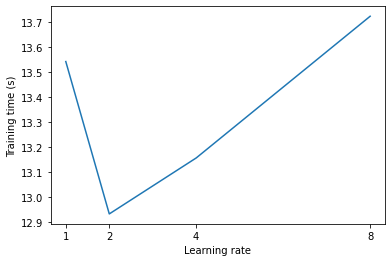

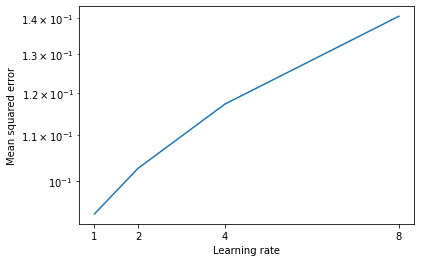

In [41]:
lr = [1.0, 2.0, 4.0, 8.0]
plt.plot(lr, train_time)
# plt.yscale('log')
plt.ylabel('Training time (s)')
plt.xticks(ticks=lr)
plt.xlabel('Learning rate')
plt.savefig('tt_vs_lr.png')
plt.show()
plt.plot(lr, train_error)
plt.yscale('log')
plt.ylabel('Mean squared error')
plt.xticks(ticks=lr)
plt.xlabel('Learning rate')
plt.savefig('te_vs_lr.png')                                                                                                                     
plt.show()